In [1]:
library(Seurat)
library(dplyr)
library(reticulate)
library(sctransform)
library(cowplot)
library(ggplot2)
# library(viridis)
library(tidyr)
library(magrittr)
library(reshape2)
# library(readxl)
# library(progeny)
# library(readr)
library(stringr)

library(Signac)
library(Seurat)
library(GenomeInfoDb)
# library(EnsDb.Mmusculus.v98)
library(ggplot2)


#R.version.string         # Show R version
# R.home() 

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.7.2 but the current
version is 1.7.3; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:SeuratObject’:

  

In [2]:
data=readRDS("/archive/bioinformatics/Zhou_lab/shared/dcai/054_LA/3_10x_Aging_nonHC_ATAC/NonHC_scATAC.rds")#Please download it from GEO

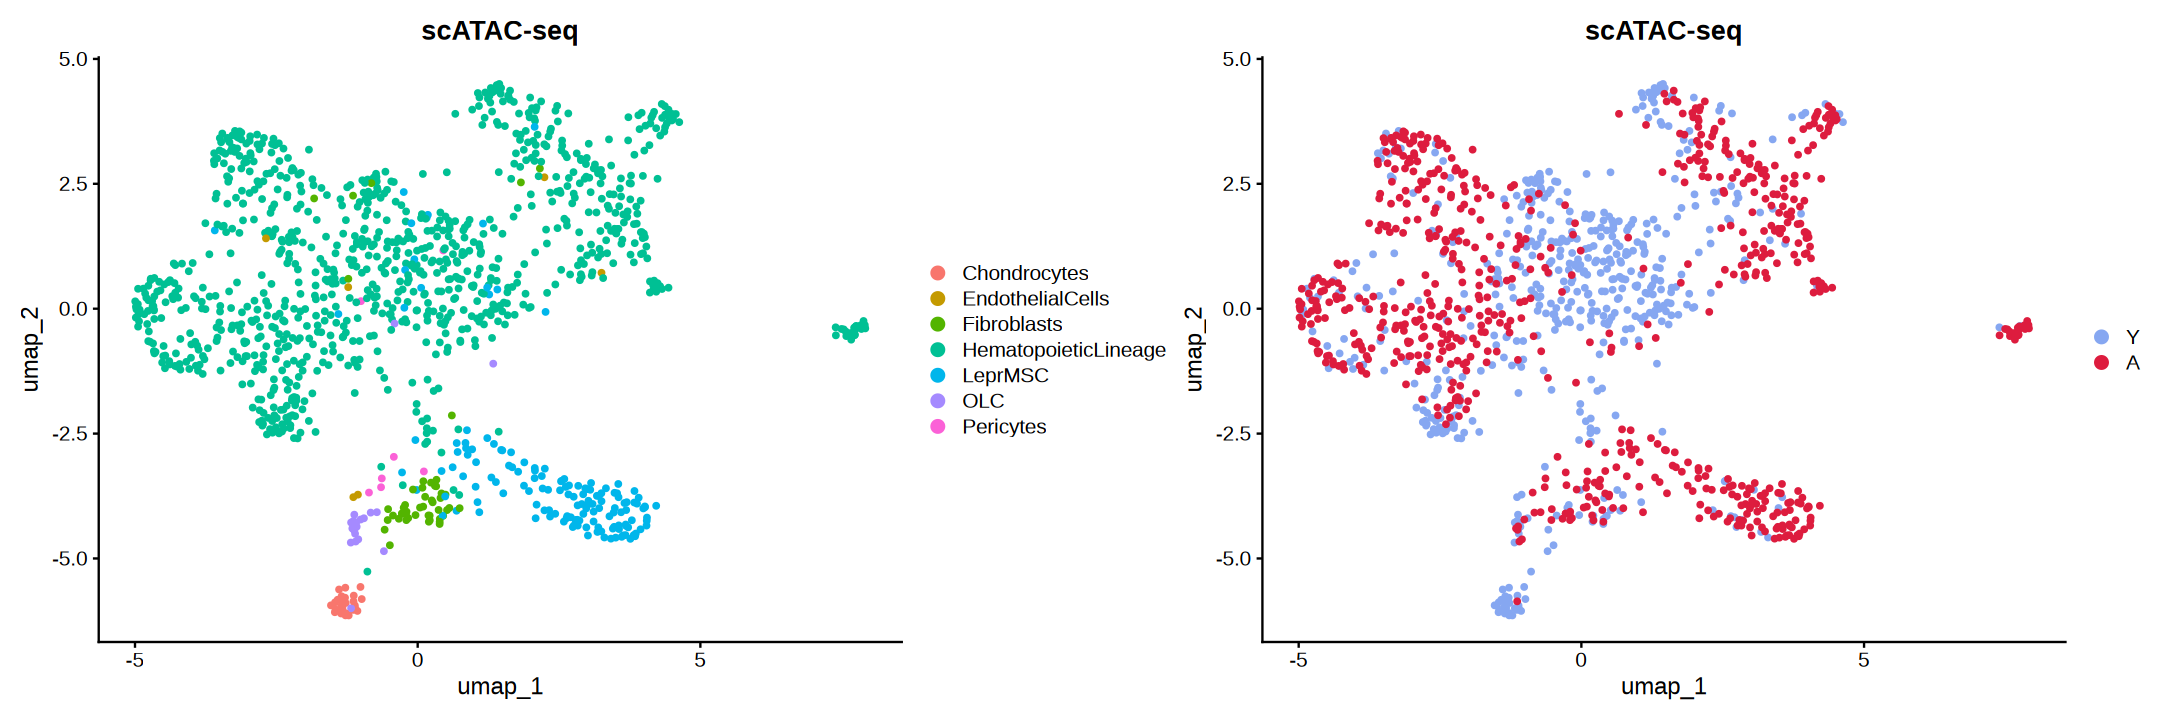

In [4]:
options(repr.plot.width = 18, repr.plot.height = 6)
plot1 <- DimPlot(
  object = data,
  group.by = 'predicted.id',
  # label = TRUE,
  repel = TRUE) + ggtitle('scATAC-seq')

plot2 <- DimPlot(
  object = data,
  group.by = 'dataset',
  # label = TRUE,
    cols=c("#86A7F1","#DD1C3E"),
  repel = TRUE)  + ggtitle('scATAC-seq')

plot1+plot2

Warning message:
“Could not find Lepr in the default search locations, found in ‘RNA’ assay instead”
Warning message:
“Could not find S100a4 in the default search locations, found in ‘RNA’ assay instead”
Warning message:
“Could not find Acan in the default search locations, found in ‘RNA’ assay instead”
Warning message:
“Could not find Bglap in the default search locations, found in ‘RNA’ assay instead”
Warning message:
“Could not find Cdh5 in the default search locations, found in ‘RNA’ assay instead”
Warning message:
“Could not find Acta2 in the default search locations, found in ‘RNA’ assay instead”


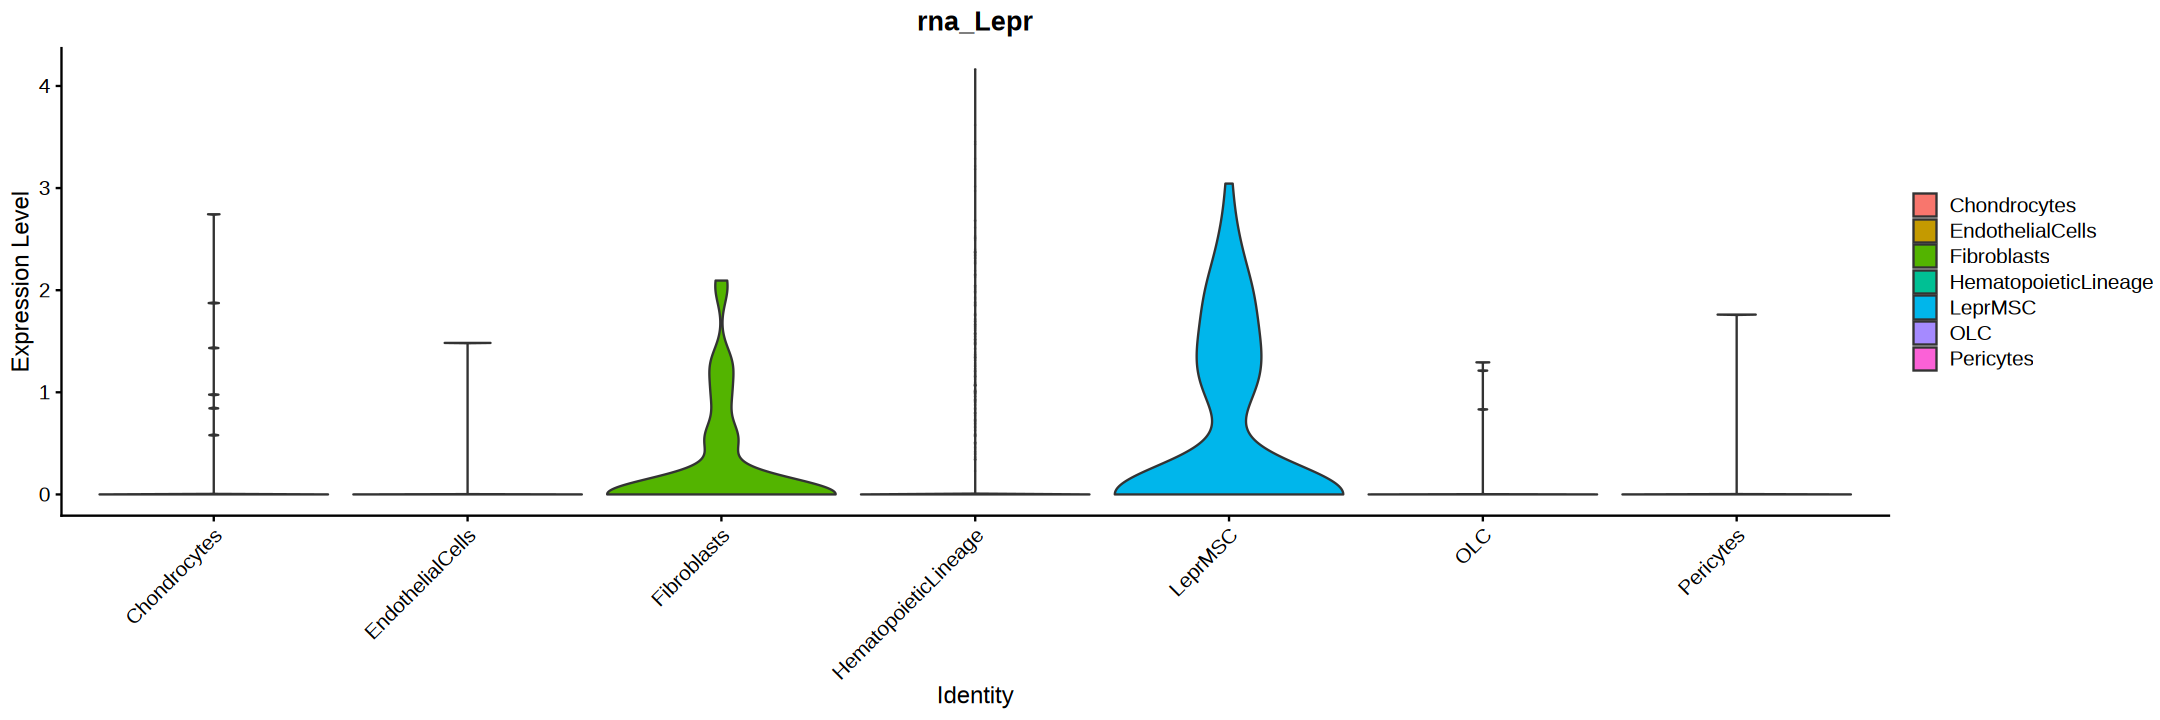

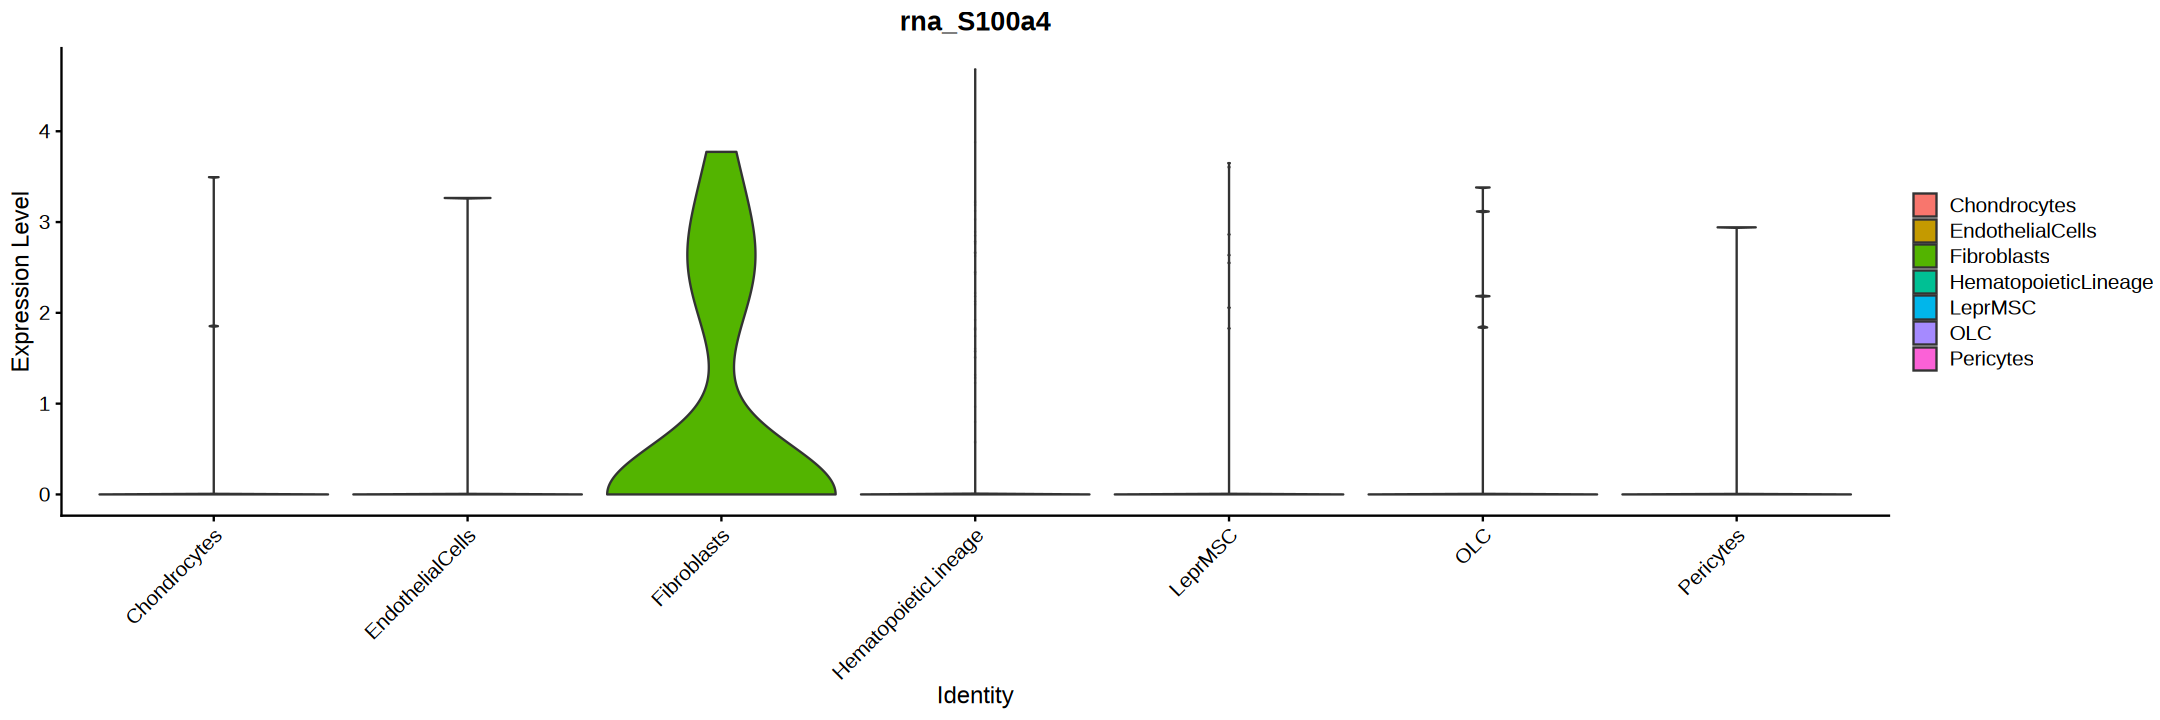

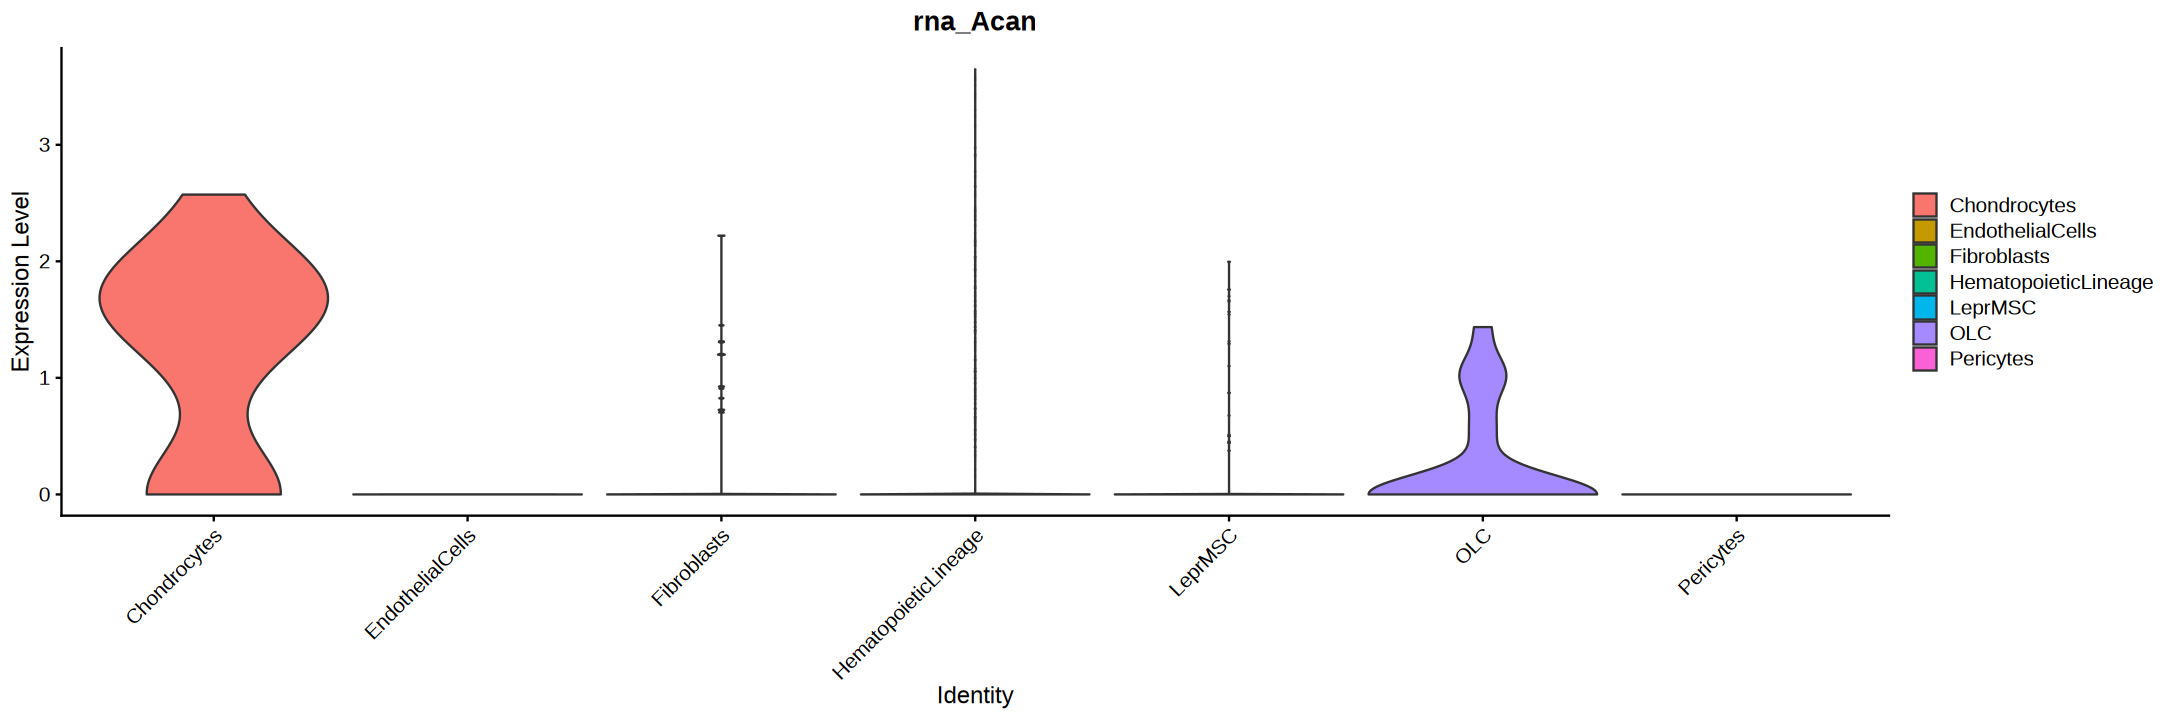

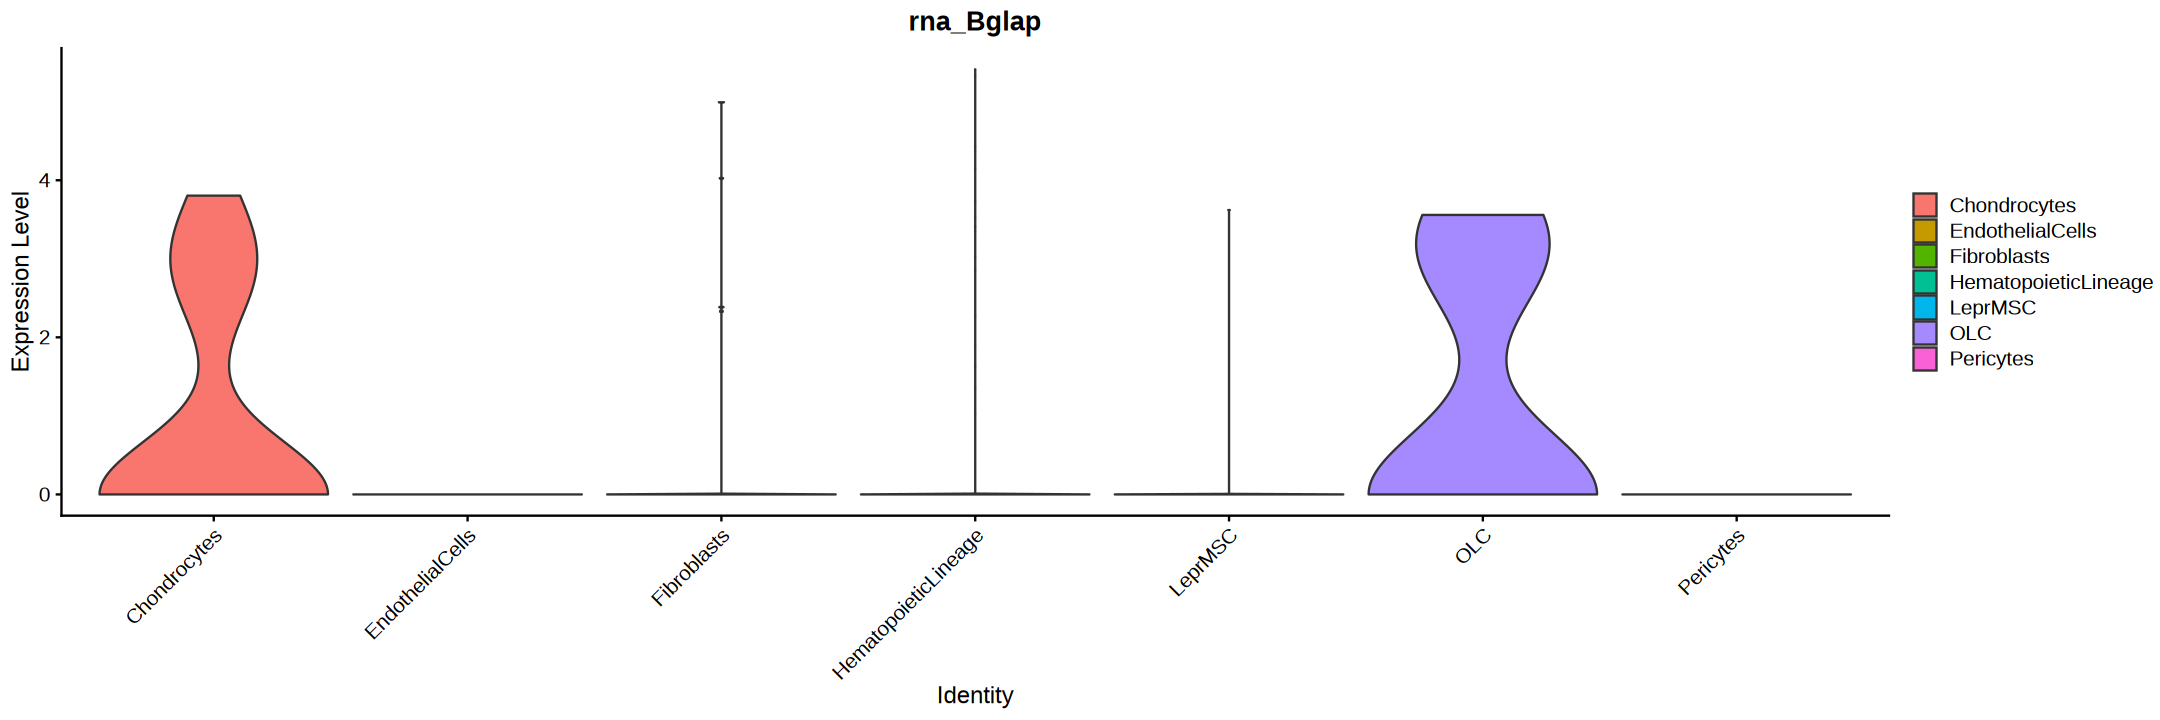

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]


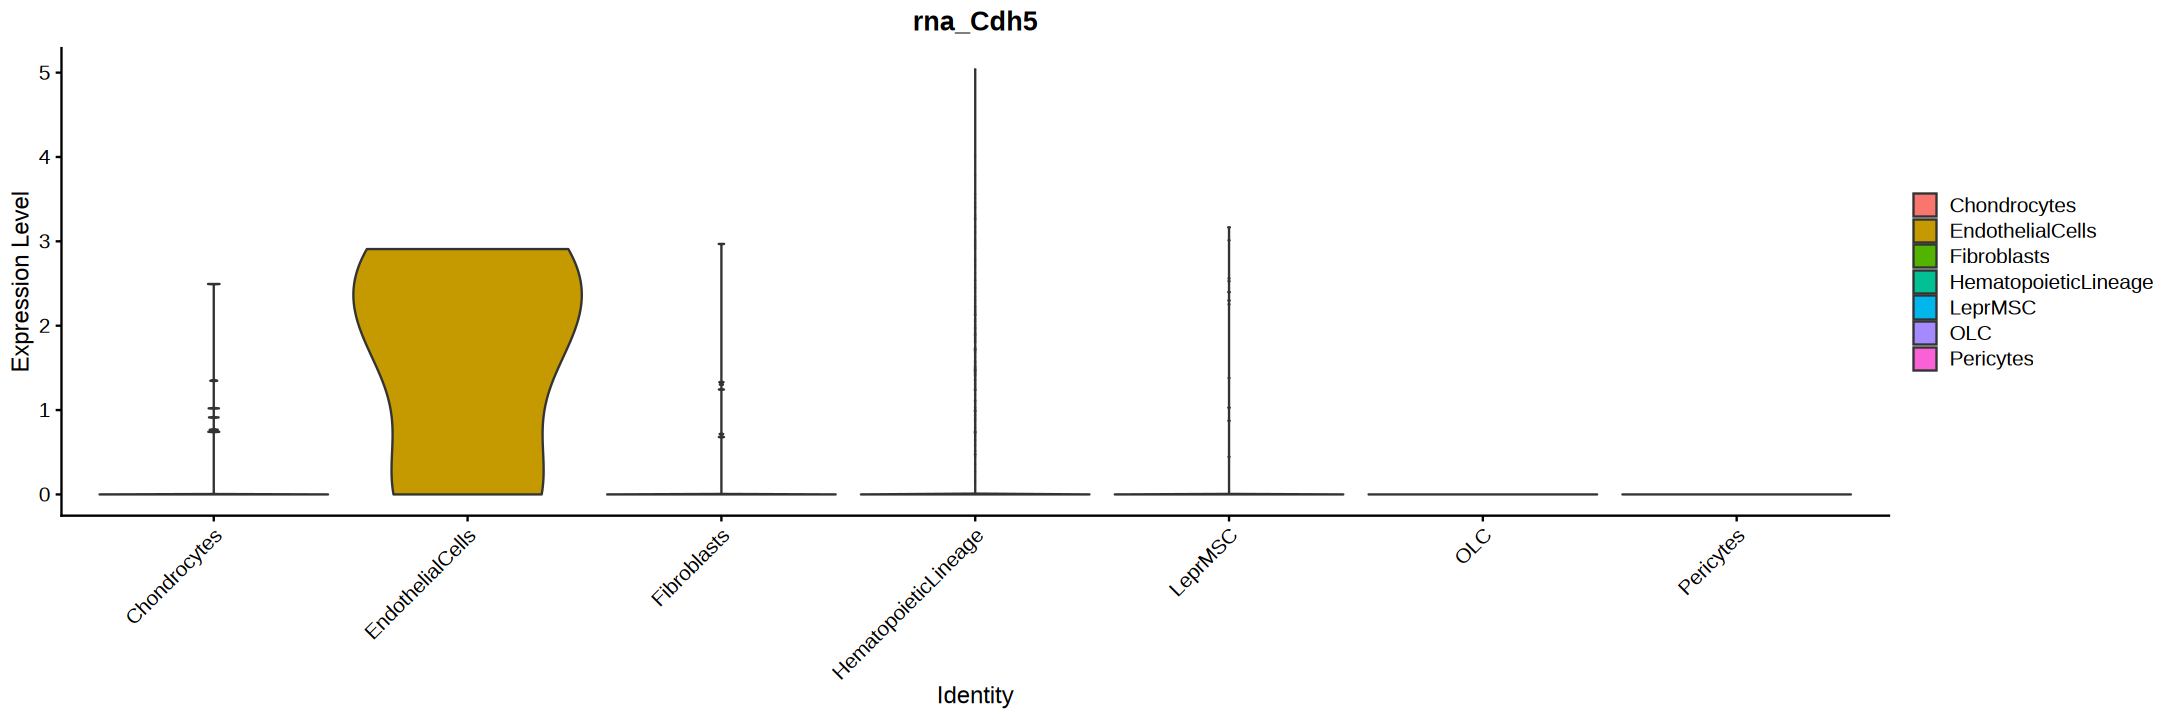

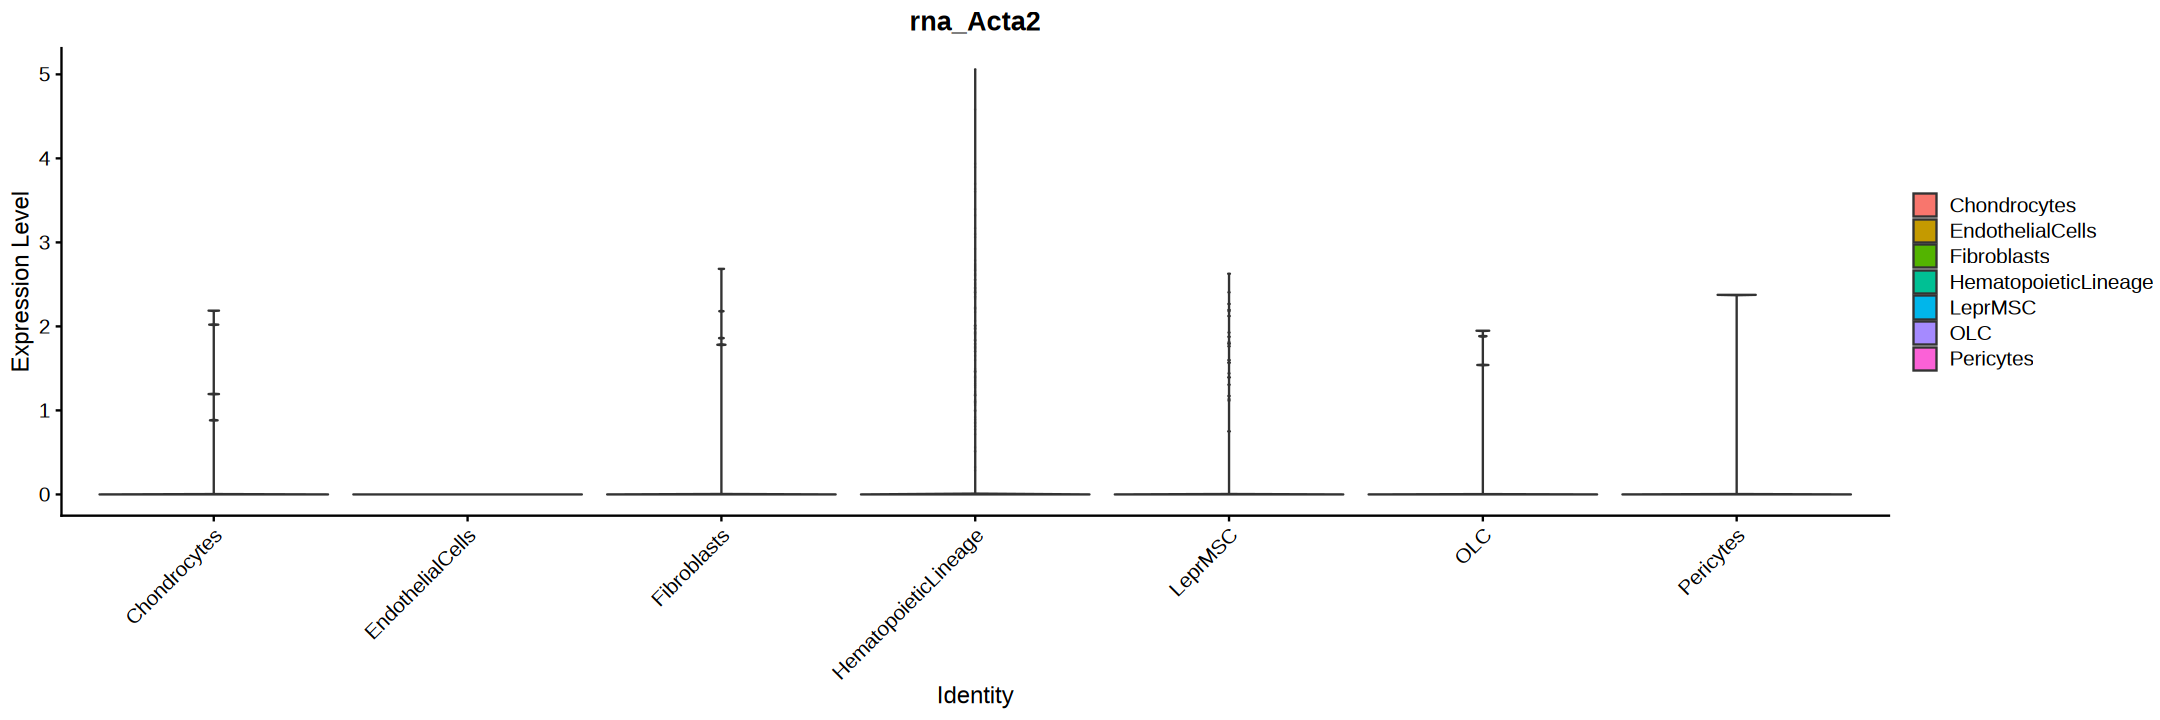

In [5]:
VlnPlot(data, features = c("Lepr","S100a4","Acan","Bglap","Cdh5","Acta2"), group.by = "predicted.id", pt.size = 0, combine = FALSE)


In [17]:
celltype=unique(data@meta.data$predicted.id)
celltype=celltype[c(1,4,3,5,6,7,2)]
## DEpeak across cell types 
Idents(data) <- "predicted.id"
DEpeak=list()
for (i in celltype){
    data_sub=data
    data_sub@meta.data$predicted.id[data_sub@meta.data$predicted.id!=i]="other"
    Idents(data_sub) <- "predicted.id"
    DefaultAssay(data_sub) ="peaks"
    data_sub_peak=FindMarkers(data_sub, ident.1 = i, ident.2 = "other",test.use = 'wilcox',min.pct = 0.1, verbose = FALSE)
    DEpeak[[i]]=data_sub_peak   
}
DEpeaks_ID=c()
for (i in celltype){

        DEpeaks_ID=c(DEpeaks_ID,rownames(DEpeak[[i]][DEpeak[[i]]$avg_log2FC > 3 & DEpeak[[i]]$p_val<0.05& DEpeak[[i]]$pct.1>0.05, ]))
    
}

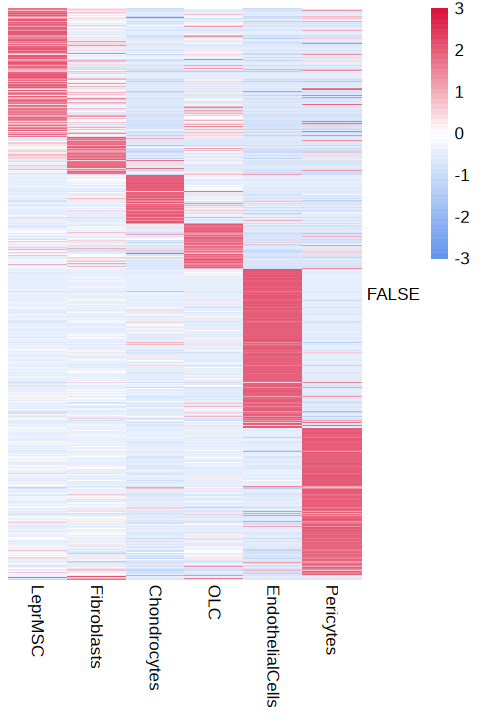

In [18]:
meta=data@meta.data
meta=meta[order(match(meta$predicted.id,celltype)),]
DEpeak_data=matrix(0,nrow=length(DEpeaks_ID),ncol=7)
rownames(DEpeak_data)=DEpeaks_ID
colnames(DEpeak_data)=celltype
for (i in celltype){
    DEpeak_data[,i]=rowMeans(data@assays$peaks@data[DEpeaks_ID,rownames(meta[meta$predicted.id==i,])])
    
}
library(pheatmap)
my_colors <- colorRampPalette(c("#6495ED","white","#DC143C"))(50)

my_breaks <- seq(-3, 3, length.out = 51)

options(repr.plot.width = 4, repr.plot.height = 6)

p=pheatmap(as.matrix(DEpeak_data)[,c(1:6)], cluster_rows = FALSE, cluster_cols = FALSE,scale="row",labels_row = FALSE, color = my_colors, breaks = my_breaks,)

ggplot_object <- p$gtable

In [11]:
Idents(data) <- "predicted.id"
DEpeak=list()
for (i in celltype[c(1,2,4,5)]){
    data_sub=subset(data, idents = i)
    Idents(data_sub) <- "dataset"
    DefaultAssay(data_sub) ="peaks"
    data_sub_peak=FindMarkers(data_sub,  ident.1 = "A", ident.2 = "Y",test.use = 'wilcox',min.pct = 0.1, verbose = FALSE)
    
    DEpeak[[i]]=data_sub_peak
    
}

In [12]:
DEpeak_CloseGenes_up=list()
DEpeak_CloseGenes_down=list()
DEpeaks_upID=c()
DEpeaks_downID=c()
for (i in celltype[c(1,2,4)]){
    DEpeak_CloseGenes_up[[i]]=ClosestFeature(data,regions =rownames(DEpeak[[i]][(DEpeak[[i]]$avg_log2FC) > 3 & DEpeak[[i]]$p_val<0.05, ]))
    DEpeak_CloseGenes_down[[i]]=ClosestFeature(data,regions =rownames(DEpeak[[i]][(DEpeak[[i]]$avg_log2FC) < -3 & DEpeak[[i]]$p_val<0.05, ]))
    DEpeaks_upID=c(DEpeaks_upID,rownames(DEpeak[[i]][(DEpeak[[i]]$avg_log2FC) > 3 & DEpeak[[i]]$p_val<0.05& DEpeak[[i]]$pct.1>0.05, ]))
    DEpeaks_downID=c(DEpeaks_downID,rownames(DEpeak[[i]][(DEpeak[[i]]$avg_log2FC) < -3 & DEpeak[[i]]$p_val<0.05& DEpeak[[i]]$pct.2>0.05, ]))
      
}

In [13]:
DEpeaks_ID=c(DEpeaks_upID,DEpeaks_downID)
DEpeaks_ID=unique(DEpeaks_ID)
DEpeak_data=matrix(0,nrow=length(DEpeaks_ID),ncol=3)
rownames(DEpeak_data)=DEpeaks_ID
colnames(DEpeak_data)=celltype[c(1,2,4)]

for (i in celltype[c(1,2,4)]){
    DEpeak_data[,i]=DEpeak[[i]][DEpeaks_ID,]$avg_log2FC

    }

DEpeak_data[is.na(DEpeak_data)]=0
DEpeak_data=DEpeak_data[order(rowSums(DEpeak_data), decreasing = TRUE), ]


In [14]:
Total_rank=c()

DEpeak_data_3_ID=rownames(DEpeak_data[rowSums(DEpeak_data>3)==3, ])
Total_rank=c(Total_rank,DEpeak_data_3_ID)
DEpeak_data_2=DEpeak_data[!rownames(DEpeak_data)%in%DEpeak_data_3_ID , ]
DEpeak_data_2=DEpeak_data_2[rowSums(DEpeak_data_2>3)==2, ]
DEpeak_data_2_ID=rownames(DEpeak_data_2[rowSums(DEpeak_data_2[,c(1,2)]>3)==2, ])
DEpeak_data_2=DEpeak_data_2[!rownames(DEpeak_data_2)%in%DEpeak_data_2_ID , ]
DEpeak_data_2_ID=c(DEpeak_data_2_ID,rownames(DEpeak_data_2[rowSums(DEpeak_data_2[,c(1,3)]>3)==2, ]))
Total_rank=c(Total_rank,DEpeak_data_2_ID)
DEpeak_data_2=DEpeak_data_2[!rownames(DEpeak_data_2)%in%DEpeak_data_2_ID , ]
DEpeak_data_2_ID=c(DEpeak_data_2_ID,rownames(DEpeak_data_2[rowSums(DEpeak_data_2[,c(2,3)]>3)==2, ]))
DEpeak_data_2_ID3=rownames(DEpeak_data_2[rowSums(DEpeak_data_2[,c(2,3)]>3)==2, ])
DEpeak_data_1=DEpeak_data[!rownames(DEpeak_data)%in%c(DEpeak_data_3_ID,DEpeak_data_2_ID), ]
DEpeak_data_1=DEpeak_data_1[rowSums(DEpeak_data_1>3)==1, ]

DEpeak_data_1_ID=rownames(DEpeak_data_1[(DEpeak_data_1[,c(1)]>3)==1, ])
Total_rank=c(Total_rank,DEpeak_data_1_ID,DEpeak_data_2_ID3)
DEpeak_data_1=DEpeak_data_1[!rownames(DEpeak_data_1)%in%DEpeak_data_1_ID , ]
DEpeak_data_1_ID=c(DEpeak_data_1_ID,rownames(DEpeak_data_1[(DEpeak_data_1[,c(2)]>3)==1,]))
Total_rank=c(Total_rank,rownames(DEpeak_data_1[(DEpeak_data_1[,c(2)]>3)==1,]))
DEpeak_data_1=DEpeak_data_1[!rownames(DEpeak_data_1)%in%DEpeak_data_1_ID , ]
DEpeak_data_1_ID=c(DEpeak_data_1_ID,rownames(DEpeak_data_1[(DEpeak_data_1[,c(3)]>3)==1,]))
Total_rank=c(Total_rank,rownames(DEpeak_data_1[(DEpeak_data_1[,c(3)]>3)==1,]))


DEpeak_data_4=DEpeak_data[!rownames(DEpeak_data)%in%c(DEpeak_data_3_ID,DEpeak_data_2_ID,DEpeak_data_1_ID), ]
DEpeak_data_4=DEpeak_data_4[order(rowSums(DEpeak_data_4), decreasing = TRUE), ]
DEpeak_data_4_ID=rownames(DEpeak_data_4)
Total_rank=c(Total_rank,DEpeak_data_4_ID)


In [15]:
DEpeak_data=DEpeak_data[Total_rank,]
dim(DEpeak_data)

[1] 7929    3

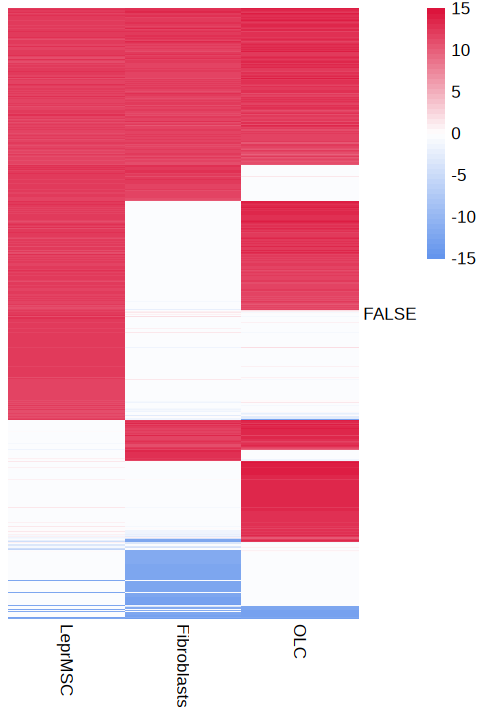

In [16]:
my_colors <- colorRampPalette(c("#6495ED","white","#DC143C"))(50)

my_breaks <- seq(-15, 15, length.out = 51)

options(repr.plot.width = 4, repr.plot.height = 6)

p=pheatmap(as.matrix(DEpeak_data)[,c(1:3)], cluster_rows = FALSE, cluster_cols = FALSE,labels_row = FALSE, color = my_colors, breaks = my_breaks,)

ggplot_object <- p$gtable



In [3]:
##Motif
library(motifmatchr)
library(BSgenome.Mmusculus.UCSC.mm10)
library(patchwork)
library(TFBSTools)
library(JASPAR2020)
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

# add motif information
data <- AddMotifs(
  object = data,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  pfm = pfm
)



Loading required package: BSgenome

Loading required package: GenomicRanges


Attaching package: ‘GenomicRanges’


The following object is masked from ‘package:magrittr’:

    subtract


Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO


Attaching package: ‘BiocIO’


The following object is masked from ‘package:reticulate’:

    import


Loading required package: rtracklayer


Attaching package: ‘rtracklayer’


The following object is masked from ‘package:BiocIO’:

    FileForFormat



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Building motif matrix

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, 

In [4]:
pfm_id_name <- data.frame(
  name = sapply(pfm, name),
  id = sapply(pfm, ID)
)

In [5]:
##ChromVAR

data <- RunChromVAR(
  object = data,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

Computing GC bias per region

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, chr6_GL456065_alt, chr6_JH584264_alt, chr7_GL455989_alt, chr7_GL456013_alt, chr7_GL456014_alt, chr8_GL455996_alt, chr8_GL45599

In [37]:
celltype=unique(data@meta.data$predicted.id)
celltype=celltype[c(1,4,3,5,6,7,2)]
celltype


DefaultAssay(data) <- 'chromvar'
Idents(data) <- "predicted.id"
DEpeak=list()
for (i in celltype){
    data_sub=data
    data_sub@meta.data$predicted.id[data_sub@meta.data$predicted.id!=i]="other"
    Idents(data_sub) <- "predicted.id"
    DefaultAssay(data_sub) ="chromvar"
    data_sub_peak=FindMarkers(data_sub, ident.1 = i, ident.2 = "other",test.use = 'wilcox',min.pct = 0.1, verbose = FALSE)


    DEpeak[[i]]=data_sub_peak

    
}
DEpeaks_ID=c()
for (i in celltype){

    DEpeaks_ID=c(DEpeaks_ID,rownames(DEpeak[[i]][DEpeak[[i]]$avg_log2FC > 3 & DEpeak[[i]]$p_val<0.05& DEpeak[[i]]$pct.1>0.05, ]))
    
}

[1] "LeprMSC"              "Fibroblasts"          "Chondrocytes"        
[4] "OLC"                  "EndothelialCells"     "Pericytes"           
[7] "HematopoieticLineage"

Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.2, drop = FALSE]):
“NaNs produced”


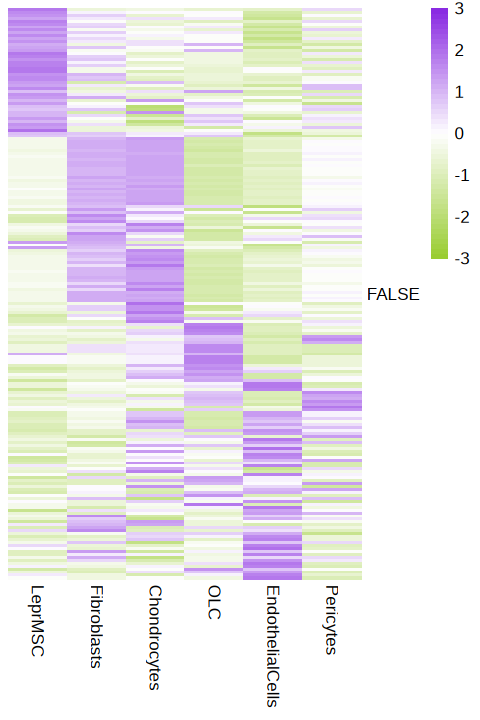

In [38]:
meta=data@meta.data
meta=meta[order(match(meta$predicted.id,celltype)),]
DEpeak_data=matrix(0,nrow=length(DEpeaks_ID),ncol=7)
rownames(DEpeak_data)=DEpeaks_ID
colnames(DEpeak_data)=celltype
for (i in celltype){
    DEpeak_data[,i]=rowMeans(data@assays$chromvar@data[DEpeaks_ID,rownames(meta[meta$predicted.id==i,])])
    
}
my_colors <- colorRampPalette(c("#9ACD32","white","#8A2BE2"))(50)

my_breaks <- seq(-3, 3, length.out = 51)

options(repr.plot.width = 4, repr.plot.height = 6)

p=pheatmap(as.matrix(DEpeak_data)[,c(1:6)], cluster_rows = FALSE, cluster_cols = FALSE,scale="row",labels_row = FALSE, color = my_colors, breaks = my_breaks,)

ggplot_object <- p$gtable


Computing Tn5 insertion bias

Extracting reads in requested region

Extracting reads in requested region

Computing observed Tn5 insertions per base

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, chr6_G

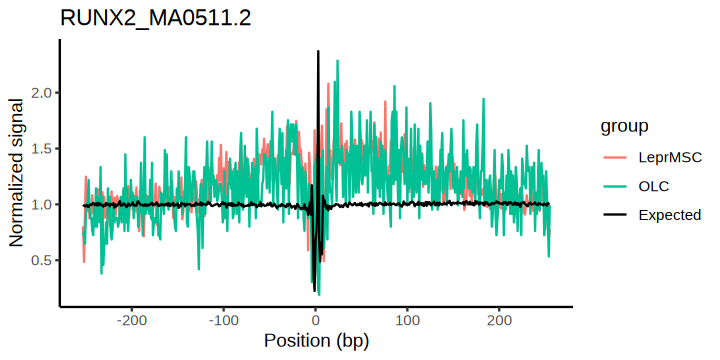

In [77]:
# gather the footprinting information for sets of motifs
DefaultAssay(data) ="peaks"

fp <- Footprint(
  object = data,
  motif.name = c("MA0511.2"),
  genome = BSgenome.Mmusculus.UCSC.mm10
)

footprint_data <- GetFootprintData(
  object = fp,
  features =  c("MA0511.2"),
  assay = "peaks" # Replace "ATAC" with the name of your ChromatinAssay
)

footprint_data$group=as.character(footprint_data$group)
footprint_data$group[is.na(footprint_data$group)]="Expected"



footprint_data$group <- factor(footprint_data$group, levels = c('LeprMSC','Fibroblasts','Chondrocytes','OLC','EndothelialCells','Pericytes','HematopoieticLineage',"Expected"))

options(repr.plot.width = 6, repr.plot.height = 3)
p=ggplot((footprint_data[footprint_data$group%in%c("LeprMSC","OLC","Expected"),]), aes(x = position, y = norm.value, color = group)) +
  geom_line() +
  theme_classic() +
  labs(title = "RUNX2_MA0511.2", x = "Position (bp)", y = "Normalized signal")+ scale_color_manual(values = c(
  "LeprMSC" = "#F8766D",
  "Fibroblasts" = "#C49A00",
  "Chondrocytes" = "#53B400",
  "OLC" = "#00C094",
  "EndothelialCells" = "#00B6EB",
  "Pericytes" = "#A58AFF",    
  "Expected" = "black"
))
p


[1] 0
[1] 509
[1] 1018
[1] 1527
[1] 2036
[1] 2545
[1] 3054
[1] 3563


Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”


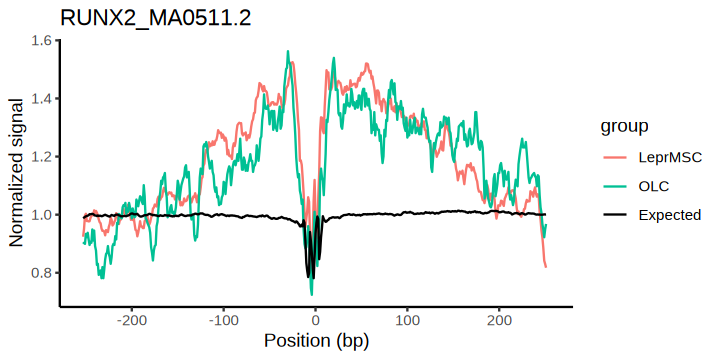

In [78]:
v=c()
window_size <- 10
kernel <- rep(1 / window_size, window_size)
# smoothed <- convolve(signal, rev(kernel), type = "filter")

for (i in unique(footprint_data$group)){
    print(length(v))
    signal=footprint_data[footprint_data$group==(i),]$norm.value
    pad <- floor(window_size / 2)
    signal_pad <- c(rep(signal[1], pad), signal, rep(signal[length(signal)], pad))
    smoothed_full=convolve(signal_pad, rev(kernel), type = "filter")
    smoothed <- smoothed_full[(pad + 1):(pad + length(signal))]
    v=c(v,smoothed)
}


footprint_data["norm.value_ave10"]=v

options(repr.plot.width = 6, repr.plot.height = 3)
p=ggplot((footprint_data[footprint_data$group%in%c("LeprMSC","OLC","Expected"),]), aes(x = position, y = norm.value_ave10, color = group)) +
  geom_line() +
  theme_classic() +
  labs(title = "RUNX2_MA0511.2", x = "Position (bp)", y = "Normalized signal")+ scale_color_manual(values = c(
  "LeprMSC" = "#F8766D",
  "Fibroblasts" = "#C49A00",
  "Chondrocytes" = "#53B400",
  "OLC" = "#00C094",
  "EndothelialCells" = "#00B6EB",
  "Pericytes" = "#A58AFF",    
  "Expected" = "black"
))
p
ggsave("/archive/bioinformatics/Zhou_lab/shared/dcai/054_LA/3_10x_Aging_nonHC_ATAC/FootPrint_RUNX2_MA0511.2_smooth.pdf", plot = p, width = 6, height = 3)

Computing Tn5 insertion bias

Extracting reads in requested region

Extracting reads in requested region

Computing observed Tn5 insertions per base

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, chr6_G

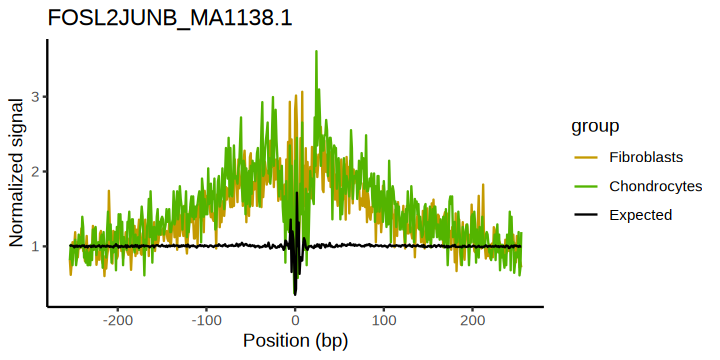

In [70]:

# gather the footprinting information for sets of motifs
DefaultAssay(data) ="peaks"

fp <- Footprint(
  object = data,
  motif.name = c("MA1138.1"),
  genome = BSgenome.Mmusculus.UCSC.mm10
)

footprint_data <- GetFootprintData(
  object = fp,
  features =  c("MA1138.1"),
  assay = "peaks" # Replace "ATAC" with the name of your ChromatinAssay
)

footprint_data$group=as.character(footprint_data$group)
footprint_data$group[is.na(footprint_data$group)]="Expected"



footprint_data$group <- factor(footprint_data$group, levels = c('LeprMSC','Fibroblasts','Chondrocytes','OLC','EndothelialCells','Pericytes','HematopoieticLineage',"Expected"))

options(repr.plot.width = 6, repr.plot.height = 3)
p=ggplot((footprint_data[footprint_data$group%in%c("Fibroblasts","Chondrocytes","Expected"),]), aes(x = position, y = norm.value, color = group)) +
  geom_line() +
  theme_classic() +
  labs(title = "FOSL2JUNB_MA1138.1", x = "Position (bp)", y = "Normalized signal")+ scale_color_manual(values = c(
  "LeprMSC" = "#F8766D",
  "Fibroblasts" = "#C49A00",
  "Chondrocytes" = "#53B400",
  "OLC" = "#00C094",
  "EndothelialCells" = "#00B6EB",
  "Pericytes" = "#A58AFF",    
  "Expected" = "black"
))
p

Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”


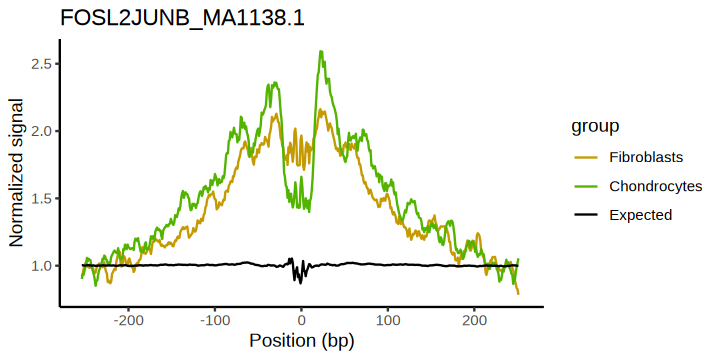

In [73]:
v=c()
window_size <- 10
kernel <- rep(1 / window_size, window_size)
# smoothed <- convolve(signal, rev(kernel), type = "filter")

for (i in unique(footprint_data$group)){
    # print(length(v))
    signal=footprint_data[footprint_data$group==(i),]$norm.value
    pad <- floor(window_size / 2)
    signal_pad <- c(rep(signal[1], pad), signal, rep(signal[length(signal)], pad))
    smoothed_full=convolve(signal_pad, rev(kernel), type = "filter")
    smoothed <- smoothed_full[(pad + 1):(pad + length(signal))]
    v=c(v,smoothed)
}


footprint_data["norm.value_ave10"]=v



options(repr.plot.width = 6, repr.plot.height = 3)
p=ggplot((footprint_data[footprint_data$group%in%c("Fibroblasts","Chondrocytes","Expected"),]), aes(x = position, y = norm.value_ave10, color = group)) +
  geom_line() +
  theme_classic() +
  labs(title = "FOSL2JUNB_MA1138.1", x = "Position (bp)", y = "Normalized signal")+ scale_color_manual(values = c(
  "LeprMSC" = "#F8766D",
  "Fibroblasts" = "#C49A00",
  "Chondrocytes" = "#53B400",
  "OLC" = "#00C094",
  "EndothelialCells" = "#00B6EB",
  "Pericytes" = "#A58AFF",    
  "Expected" = "black"
))
p
ggsave("/archive/bioinformatics/Zhou_lab/shared/dcai/054_LA/3_10x_Aging_nonHC_ATAC/FootPrint_FOSL2JUNB_MA1138.1_smooth.pdf", plot = p, width = 6, height = 3)

Computing Tn5 insertion bias

Extracting reads in requested region

Extracting reads in requested region

Computing observed Tn5 insertions per base

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, chr6_G

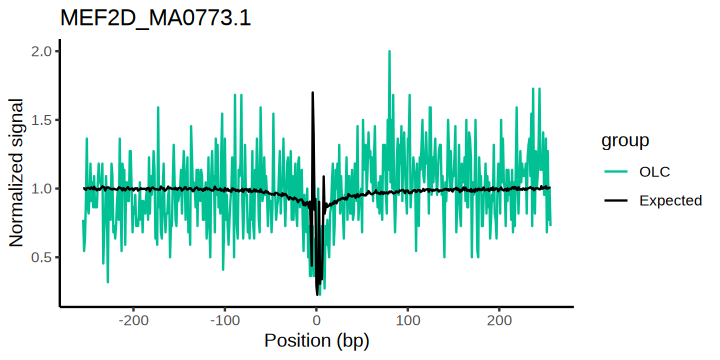

In [74]:
# gather the footprinting information for sets of motifs
DefaultAssay(data) ="peaks"

fp <- Footprint(
  object = data,
  motif.name = c("MA0773.1"),
  genome = BSgenome.Mmusculus.UCSC.mm10
)

footprint_data <- GetFootprintData(
  object = fp,
  features =  c("MA0773.1"),
  assay = "peaks" # Replace "ATAC" with the name of your ChromatinAssay
)

footprint_data$group=as.character(footprint_data$group)
footprint_data$group[is.na(footprint_data$group)]="Expected"





footprint_data$group <- factor(footprint_data$group, levels = c('LeprMSC','Fibroblasts','Chondrocytes','OLC','EndothelialCells','Pericytes','HematopoieticLineage',"Expected"))

options(repr.plot.width = 6, repr.plot.height = 3)
p=ggplot((footprint_data[footprint_data$group%in%c("OLC","Expected"),]), aes(x = position, y = norm.value, color = group)) +
  geom_line() +
  theme_classic() +
  labs(title = "MEF2D_MA0773.1", x = "Position (bp)", y = "Normalized signal")+ scale_color_manual(values = c(
  "LeprMSC" = "#F8766D",
  "Fibroblasts" = "#C49A00",
  "Chondrocytes" = "#53B400",
  "OLC" = "#00C094",
  "EndothelialCells" = "#00B6EB",
  "Pericytes" = "#A58AFF",    
  "Expected" = "black"
))
p

Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”


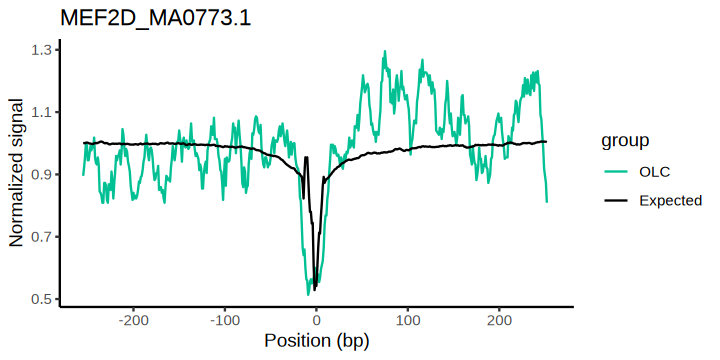

In [76]:
v=c()
window_size <- 10
kernel <- rep(1 / window_size, window_size)
# smoothed <- convolve(signal, rev(kernel), type = "filter")

for (i in unique(footprint_data$group)){
    # print(length(v))
    signal=footprint_data[footprint_data$group==(i),]$norm.value
    pad <- floor(window_size / 2)
    signal_pad <- c(rep(signal[1], pad), signal, rep(signal[length(signal)], pad))
    smoothed_full=convolve(signal_pad, rev(kernel), type = "filter")
    smoothed <- smoothed_full[(pad + 1):(pad + length(signal))]
    v=c(v,smoothed)
}


footprint_data["norm.value_ave10"]=v


footprint_data$group <- factor(footprint_data$group, levels = c('LeprMSC','Fibroblasts','Chondrocytes','OLC','EndothelialCells','Pericytes','HematopoieticLineage',"Expected"))

options(repr.plot.width = 6, repr.plot.height = 3)
p=ggplot((footprint_data[footprint_data$group%in%c("OLC","Expected"),]), aes(x = position, y = norm.value_ave10, color = group)) +
  geom_line() +
  theme_classic() +
  labs(title = "MEF2D_MA0773.1", x = "Position (bp)", y = "Normalized signal")+ scale_color_manual(values = c(
  "LeprMSC" = "#F8766D",
  "Fibroblasts" = "#C49A00",
  "Chondrocytes" = "#53B400",
  "OLC" = "#00C094",
  "EndothelialCells" = "#00B6EB",
  "Pericytes" = "#A58AFF",    
  "Expected" = "black"
))
p
ggsave("/archive/bioinformatics/Zhou_lab/shared/dcai/054_LA/3_10x_Aging_nonHC_ATAC/FootPrint_MEF2D_MA0773.1_smooth.pdf", plot = p, width = 6, height = 3)

In [79]:
## DEpeak across ages

DefaultAssay(data) <- 'chromvar'
Idents(data) <- "predicted.id"
DEpeak=list()
for (i in celltype[c(1,2,4)]){
    Idents(data) <- "predicted.id"
    data_sub=subset(data, idents = i)
    Idents(data_sub) <- "dataset"
    DefaultAssay(data_sub) ="chromvar"
    data_sub_peak=FindMarkers(data_sub,  ident.1 = "A", ident.2 = "Y",test.use = 'wilcox',min.pct = 0.1, verbose = FALSE)
    
    DEpeak[[i]]=data_sub_peak
    
}

Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.2, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.2, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.1, drop = FALSE]):
“NaNs produced”
Warning message in mean.fxn(object[features, cells.2, drop = FALSE]):
“NaNs produced”


In [81]:

DEpeaks_upID=c()
DEpeaks_downID=c()
for (i in celltype[c(1,2,4)]){
    DEpeaks_upID=c(DEpeaks_upID,rownames(DEpeak[[i]][(DEpeak[[i]]$avg_log2FC) > 3 & DEpeak[[i]]$p_val<0.05& DEpeak[[i]]$pct.1>0.05, ]))
    DEpeaks_downID=c(DEpeaks_downID,rownames(DEpeak[[i]][(DEpeak[[i]]$avg_log2FC) < -3 & DEpeak[[i]]$p_val<0.05& DEpeak[[i]]$pct.2>0.05, ]))
      
}
DEpeaks_ID=unique(c(DEpeaks_upID,DEpeaks_downID))


In [82]:


DEpeak_data=matrix(0,nrow=length(DEpeaks_ID),ncol=3)
rownames(DEpeak_data)=DEpeaks_ID
colnames(DEpeak_data)=celltype[c(1,2,4)]
for (i in celltype[c(1,2,4)]){
    DEpeak_data[,i]=DEpeak[[i]][DEpeaks_ID,]$avg_log2FC
    
}

DEpeak_data[is.na(DEpeak_data)]=0

In [83]:
DEpeak_data=cbind(pfm_id_name[rownames(DEpeak_data),],DEpeak_data)
DEpeak_data

,name,id,LeprMSC,Fibroblasts,OLC
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
MA0102.4,CEBPA,MA0102.4,15.099070,6.3917956,0.0000000
MA0836.2,CEBPD,MA0836.2,12.276333,5.9094417,4.5946203
MA0809.2,TEAD4,MA0809.2,6.583666,2.3115126,2.9178178
MA0837.1,CEBPE,MA0837.1,11.010039,5.5313806,-0.7796567
MA0466.2,CEBPB,MA0466.2,9.541747,5.4003141,-0.4698652
MA0002.2,RUNX1,MA0002.2,6.210112,1.6119126,8.3764864
MA0808.1,TEAD3,MA0808.1,6.743170,1.5442085,4.7125386
MA0518.1,Stat4,MA0518.1,5.565608,2.9320706,3.6088679
MA0838.1,CEBPG,MA0838.1,7.514051,6.4714796,1.9150497


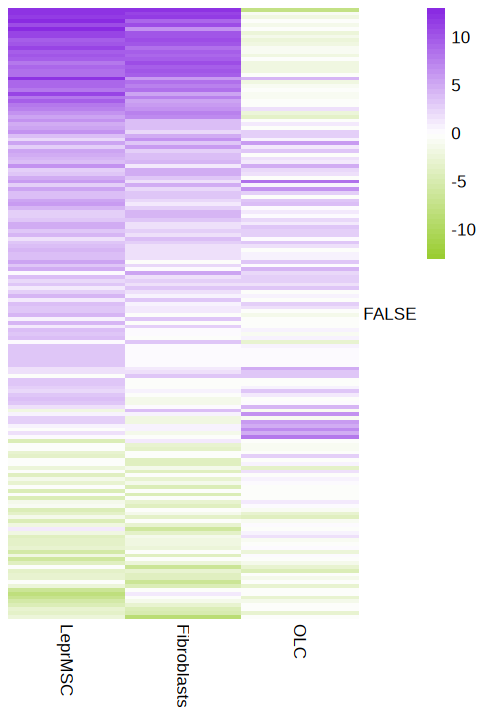

In [84]:
my_colors <- colorRampPalette(c("#9ACD32","white","#8A2BE2"))(50)

my_breaks <- seq(-13, 13, length.out = 51)

options(repr.plot.width = 4, repr.plot.height = 6)

p=pheatmap(as.matrix(DEpeak_data[order(rowSums(DEpeak_data[,c(3,4)]),decreasing=T),c(3,4,5)]), cluster_rows = FALSE, cluster_cols = FALSE,labels_row = FALSE, color = my_colors, breaks = my_breaks,)

ggplot_object <- p$gtable




In [161]:
motif="MA1141.1"

Idents(data) <- "dataset"
DefaultAssay(data) ="peaks"
fp <- Footprint(
  object = data,
  motif.name = c(motif),
  genome = BSgenome.Mmusculus.UCSC.mm10
)


In [50]:
celltype=unique(data@meta.data$predicted.id)
celltype=celltype[c(1,4,3,5,6,7,2)]
celltype

[1] "LeprMSC"              "Fibroblasts"          "Chondrocytes"        
[4] "OLC"                  "EndothelialCells"     "Pericytes"           
[7] "HematopoieticLineage"

In [162]:
p=list()


for (i in celltype[c(1,2,4)]){
footprint_data <- GetFootprintData(
  object = fp,
  features =  c(motif),
    group.by=c("dataset"),
    # idents ="predicted.id",
  assay = "peaks" # Replace "ATAC" with the name of your ChromatinAssay
)

    
Idents(fp) <- "predicted.id"
data_sub=subset(fp, idents = i)
F_Y=colMeans(data_sub@assays$peaks@positionEnrichment$`MA1141.1`[rownames(data_sub@meta.data["dataset"])[data_sub@meta.data["dataset"]=="Y"],])
F_A=colMeans(data_sub@assays$peaks@positionEnrichment$`MA1141.1`[rownames(data_sub@meta.data["dataset"])[data_sub@meta.data["dataset"]=="A"],])

window_size <- 10
kernel <- rep(1 / window_size, window_size)
pad <- floor(window_size / 2)

signal_pad <- c(rep(F_Y[1], pad), F_Y, rep(F_Y[length(F_Y)], pad))
smoothed_full=convolve(signal_pad, rev(kernel), type = "filter")
smoothed_F_Y <- smoothed_full[(pad + 1):(pad + length(F_Y))]
smoothed_F_Y=smoothed_F_Y -(smoothed_F_Y[1]-mean(footprint_data[is.na(footprint_data$group),]$norm.value))

signal_pad <- c(rep(F_A[1], pad), F_A, rep(F_A[length(F_A)], pad))
smoothed_full=convolve(signal_pad, rev(kernel), type = "filter")
smoothed_F_A <- smoothed_full[(pad + 1):(pad + length(F_A))]
smoothed_F_A=smoothed_F_A-(smoothed_F_A[1]-mean(footprint_data[is.na(footprint_data$group),]$norm.value))

footprint_data[footprint_data$group=="Y"&!is.na(footprint_data$group),]$norm.value=smoothed_F_Y
footprint_data[footprint_data$group=="A"&!is.na(footprint_data$group),]$norm.value=smoothed_F_A

footprint_data$group=as.character(footprint_data$group)
footprint_data$group[is.na(footprint_data$group)]="Expected"

footprint_data$group <- factor(footprint_data$group, levels = c('Y','A',"Expected"))

options(repr.plot.width = 6, repr.plot.height = 3)
p[[i]]=ggplot((footprint_data[footprint_data$group%in%c("Y","A","Expected"),]), aes(x = position, y = norm.value, color = group)) +
  geom_line() +
  theme_classic() +
    ylim(0, 4)+
  labs(title = i, x = "Position (bp)", y = " Normalized signal")+ scale_color_manual(values = c(
  "Y" = "#1E90FF",
  "A" = "#FF4500", 
  "Expected" = "black"
))
    


}


Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”


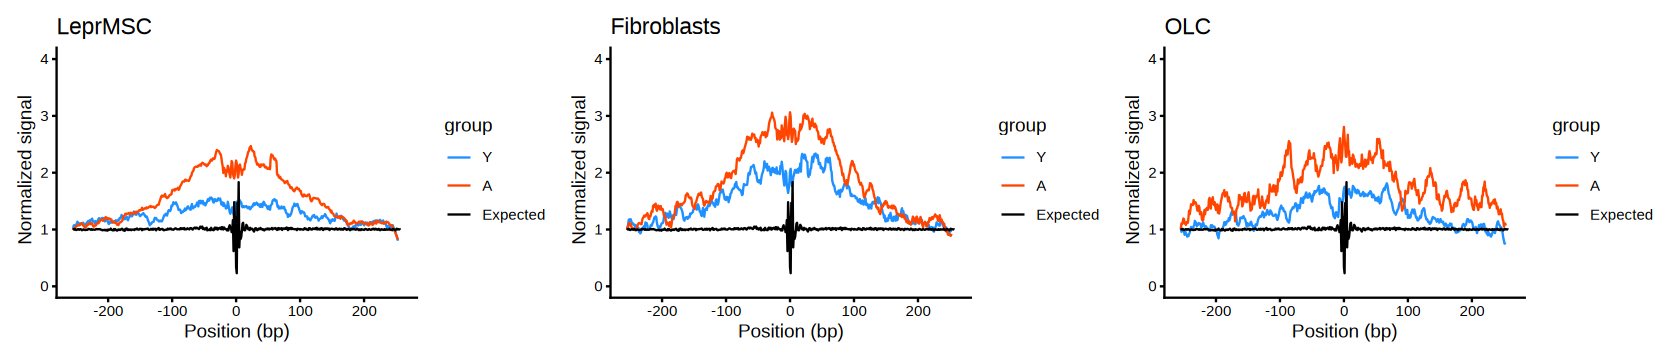

In [164]:
options(repr.plot.width = 14, repr.plot.height = 3)
p$LeprMSC+p$Fibroblasts+p$OLC+ plot_layout(nrow = 1)
combined_plot <-p$LeprMSC+p$Fibroblasts+p$OLC+ plot_layout(nrow = 1)
ggsave("/archive/bioinformatics/Zhou_lab/shared/dcai/054_LA/3_10x_Aging_nonHC_ATAC/FootPrint_Aged_FOS_JUND_MA1141.1_smooth.pdf", plot = combined_plot, width = 14, height = 3)

In [165]:
motif="MA0102.4"

Idents(data) <- "dataset"
DefaultAssay(data) ="peaks"
fp <- Footprint(
  object = data,
  motif.name = c(motif),
  genome = BSgenome.Mmusculus.UCSC.mm10
)
footprint_data <- GetFootprintData(
  object = fp,
  features =  c(motif),
    group.by=c("dataset"),
    # idents ="predicted.id",
  assay = "peaks" # Replace "ATAC" with the name of your ChromatinAssay
)

Computing Tn5 insertion bias

Extracting reads in requested region

Extracting reads in requested region

Computing observed Tn5 insertions per base

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, chr6_G

In [166]:
p=list()


for (i in celltype[c(1,2,4)]){

footprint_data <- GetFootprintData(
  object = fp,
  features =  c(motif),
    group.by=c("dataset"),
    # idents ="predicted.id",
  assay = "peaks" # Replace "ATAC" with the name of your ChromatinAssay
)


Idents(fp) <- "predicted.id"
data_sub=subset(fp, idents = i)
F_Y=colMeans(data_sub@assays$peaks@positionEnrichment$`MA0102.4`[rownames(data_sub@meta.data["dataset"])[data_sub@meta.data["dataset"]=="Y"],])
F_A=colMeans(data_sub@assays$peaks@positionEnrichment$`MA0102.4`[rownames(data_sub@meta.data["dataset"])[data_sub@meta.data["dataset"]=="A"],])

window_size <- 10
kernel <- rep(1 / window_size, window_size)
pad <- floor(window_size / 2)

signal_pad <- c(rep(F_Y[1], pad), F_Y, rep(F_Y[length(F_Y)], pad))
smoothed_full=convolve(signal_pad, rev(kernel), type = "filter")
smoothed_F_Y <- smoothed_full[(pad + 1):(pad + length(F_Y))]
smoothed_F_Y=smoothed_F_Y -(smoothed_F_Y[1]-mean(footprint_data[is.na(footprint_data$group),]$norm.value))

signal_pad <- c(rep(F_A[1], pad), F_A, rep(F_A[length(F_A)], pad))
smoothed_full=convolve(signal_pad, rev(kernel), type = "filter")
smoothed_F_A <- smoothed_full[(pad + 1):(pad + length(F_A))]
smoothed_F_A=smoothed_F_A-(smoothed_F_A[1]-mean(footprint_data[is.na(footprint_data$group),]$norm.value))

footprint_data[footprint_data$group=="Y"&!is.na(footprint_data$group),]$norm.value=smoothed_F_Y
footprint_data[footprint_data$group=="A"&!is.na(footprint_data$group),]$norm.value=smoothed_F_A
  

footprint_data$group=as.character(footprint_data$group)
footprint_data$group[is.na(footprint_data$group)]="Expected"

footprint_data$group <- factor(footprint_data$group, levels = c('Y','A',"Expected"))

options(repr.plot.width = 6, repr.plot.height = 3)
p[[i]]=ggplot((footprint_data[footprint_data$group%in%c("Y","A","Expected"),]), aes(x = position, y = norm.value, color = group)) +
  geom_line() +
  theme_classic() +
    ylim(0, 2)+
  labs(title = i, x = "Position (bp)", y = " Normalized signal")+ scale_color_manual(values = c(
  "Y" = "#1E90FF",
  "A" = "#FF4500", 
  "Expected" = "black"
))
    


}


Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”


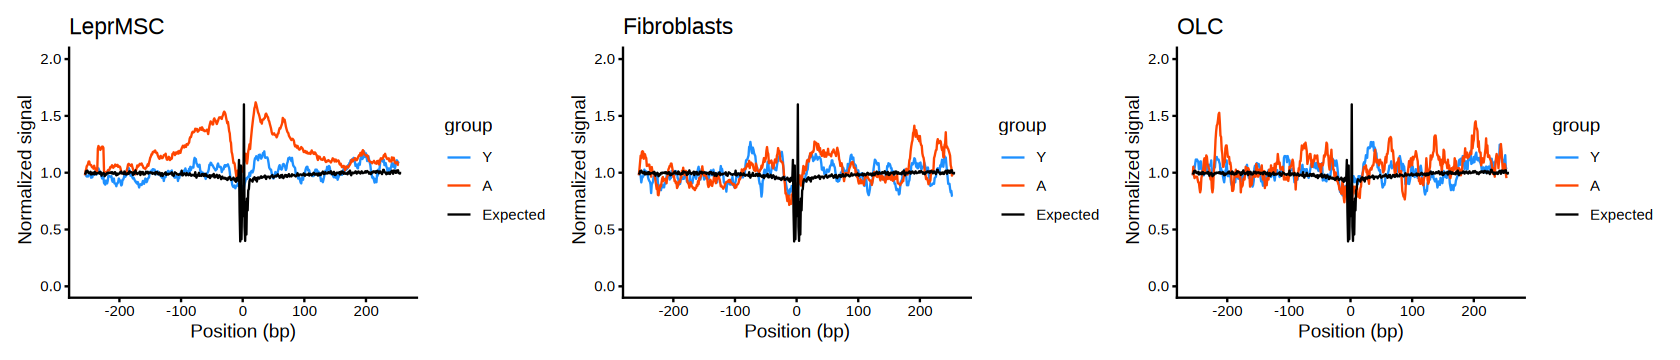

In [167]:
options(repr.plot.width = 14, repr.plot.height = 3)
p$LeprMSC+p$Fibroblasts+p$OLC+ plot_layout(nrow = 1)
combined_plot <-p$LeprMSC+p$Fibroblasts+p$OLC+ plot_layout(nrow = 1)
ggsave("/archive/bioinformatics/Zhou_lab/shared/dcai/054_LA/3_10x_Aging_nonHC_ATAC/FootPrint_Aged_CEBPA_MA0102.4_smooth.pdf", plot = combined_plot, width = 14, height = 3)